In [1]:
from IPython import display

# Domestic Perception Functionalities
We will mostly focus on Object Detection, since person recognition is somewhat separated from the other components, and should be refactored to use `mas_perception` architecture.

## Table of contents
* [Overview](#Overview)
    - [Object Detection](#Object-Detection)
    - [Object Recognition](#Object-Recognition)
* [`mas_perception_libs`](#mas_perception_libs)

## Overview
### Object Detection
Previously, object detection in `mcr_scene_segmentation` and the built-in `tabletop_segmentator` on the HSR has the following general structure

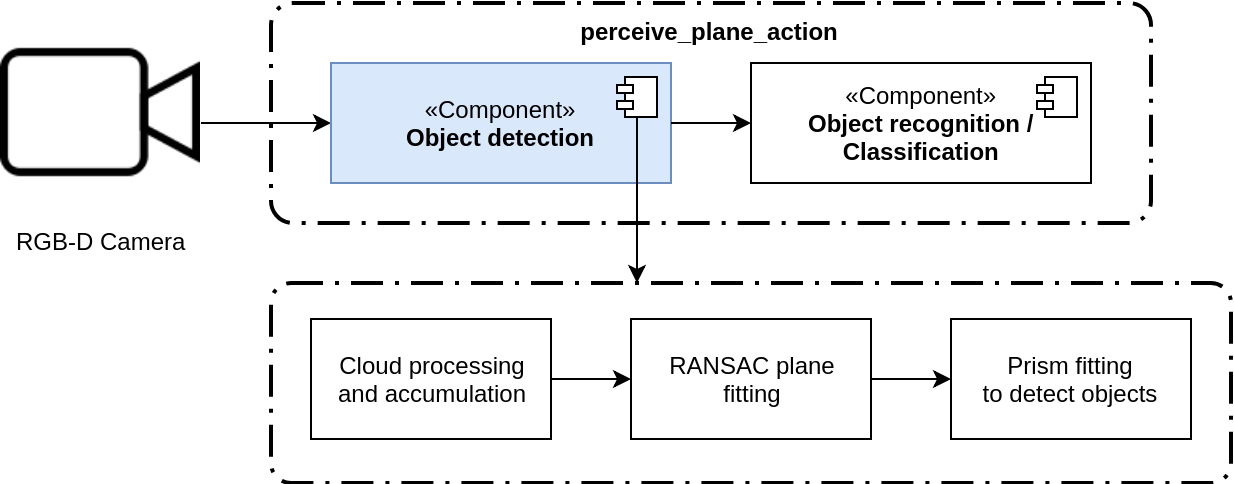

In [2]:
display.Image('images/perception_arch_detection_old.png', width=600)

On the @Home team, this architecture was modified like in the following figure:

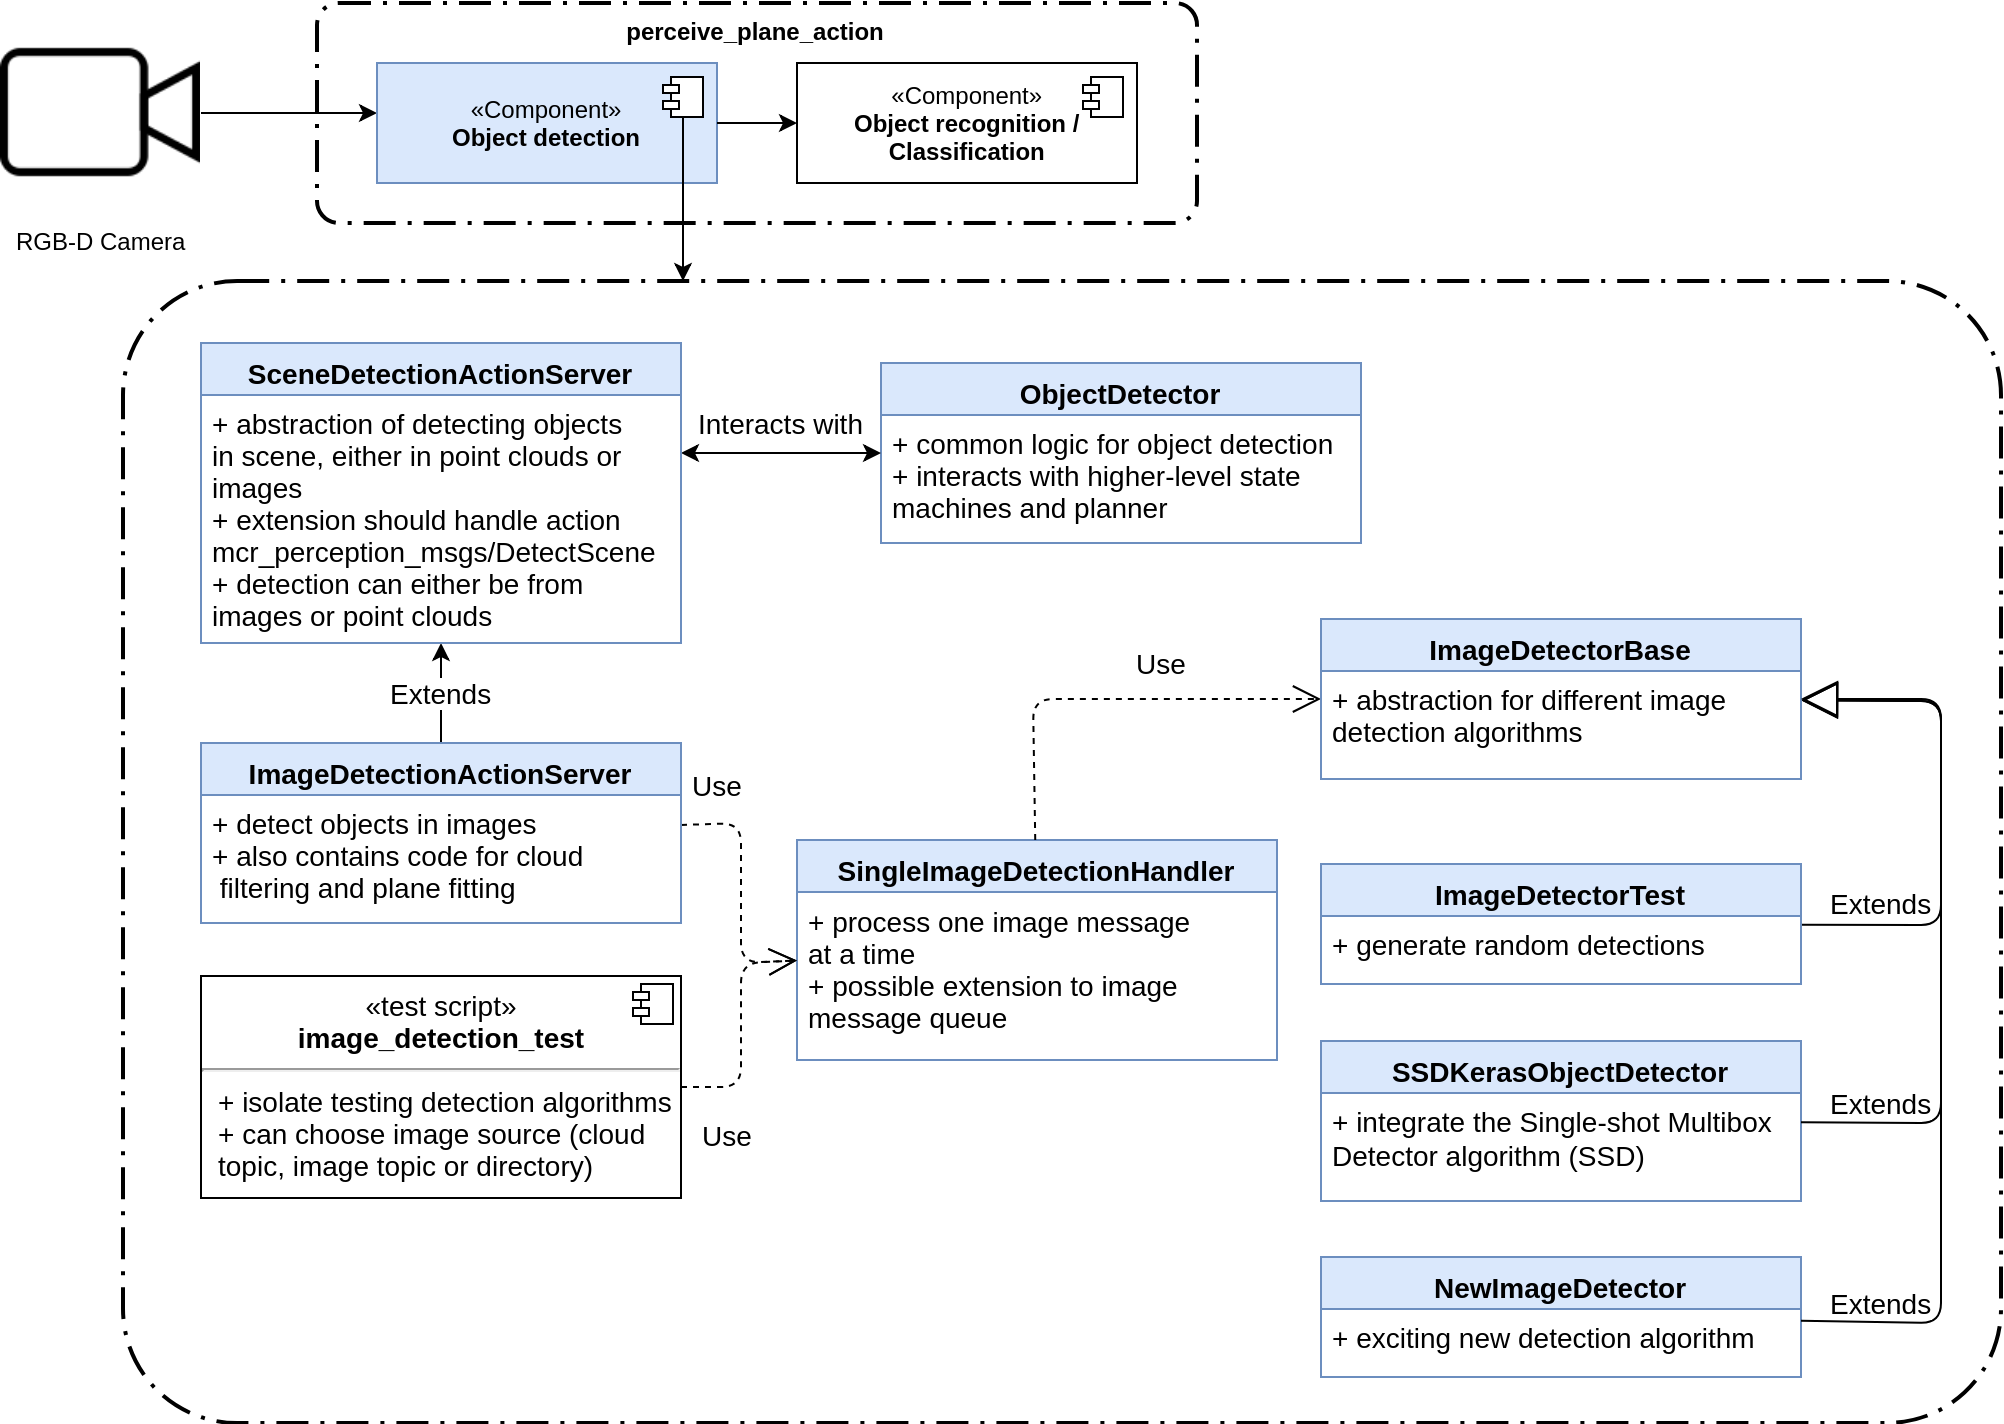

In [3]:
display.Image('images/perception_arch_detection_new.png')

There are several motivations for moving away from the older solution and going for for this design:
* Relying solely on point clouds for detection is not always reliable, especially in domestic environment, because of the variety of materials and object shapes. For example, RGB-D cameras have a particularly hard time with plastic objects, as can be seen in the following figure
* Exciting new detection algorithms tend to deal with RGB-only images which wouldn't be affected by object materials. However, many of these use deep learning (DL) libraries in Python, whereas the old detection code is written in C++.
* The fast moving pace of DL demands some form of abstraction for easing integration of new algorithms


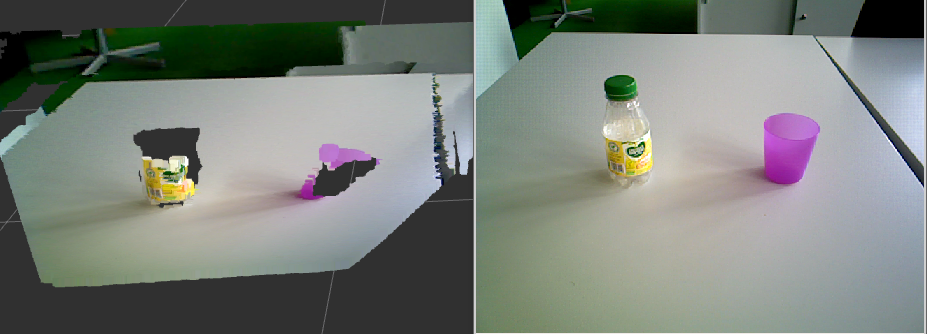

In [4]:
display.Image('images/bad_objects.png')

With the above points in mind, the main features of this architecture are:
* `ObjectDetector` (see [Python documentation](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#objectdetector) for more details) is an abstraction which interacts with higher-level state machine and planning logic.
    - It also works with the HSR built-in `tabletop_segmentator` component (this has not been tested since mid 2018, however).
    - A similar detection action server which uses `mcr_scene_segmentation` can be implemented without much effort and would be able to interact with `ObjectDetector`, as long as it properly handles the action defined in [`mcr_perception_msgs/DetectScene.action`](https://github.com/b-it-bots/mas_perception/blob/kinetic/mcr_perception_msgs/action/DetectScene.action).
* `SceneDetectionAction` is an abstraction for a handler of the `mcr_perception_msgs/DetectScene` action. The interaction with HSR's `tabletop_segmentator`, for example, is handled in an extension of this class.
* `ImageDetectorBase` (see [Python documentation](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#imagedetectorbase) for more details) is an abstraction for different image detection algorithms, which would hopefully ease the integration of new algorithms in the future.

Possible improvements for the object detection architecture:
* Combining the point cloud detection and image detection for a more robust solution can be done in `ObjectDetector`
* `SingleImageDetectionHandler` can be extended to handle multiple images (possibly a queue model). Here maybe `ImageDetectionROSHandler` maybe a more appropriate name, since ROS related code starts at this level.
* currently `ImageDetectionActionServer` handles cloud processing code such as plane fitting, cloud filtering, and object pose estimation. Pose estimation may need to be refactored to a different location, if more advanced methods are to be integrated.

### Object Recognition
The following figure shows the architecture of the image recognition/classification component. The main features:
* Common proxy and service for the [`ImageRecognition` service](https://github.com/b-it-bots/mas_perception/blob/devel/mcr_perception_msgs/srv/ImageRecognition.srv) for handling all image classification models
* `RecognizeImageService` loads all classification models from a directory, and the service request specifiy which model to use for classification
* `ImageRecognitionServiceProxy` specifies which model to use in service requests in constructor

Possible improvements:
* load all models during initialization in RecognizeImageService to avoid slow classification of first service request
* change `ImageRecognitionService` to `RecognizeImage` for consisitency with other service names (minor)
* use action server instead of service for consistency with image detection component (minor)

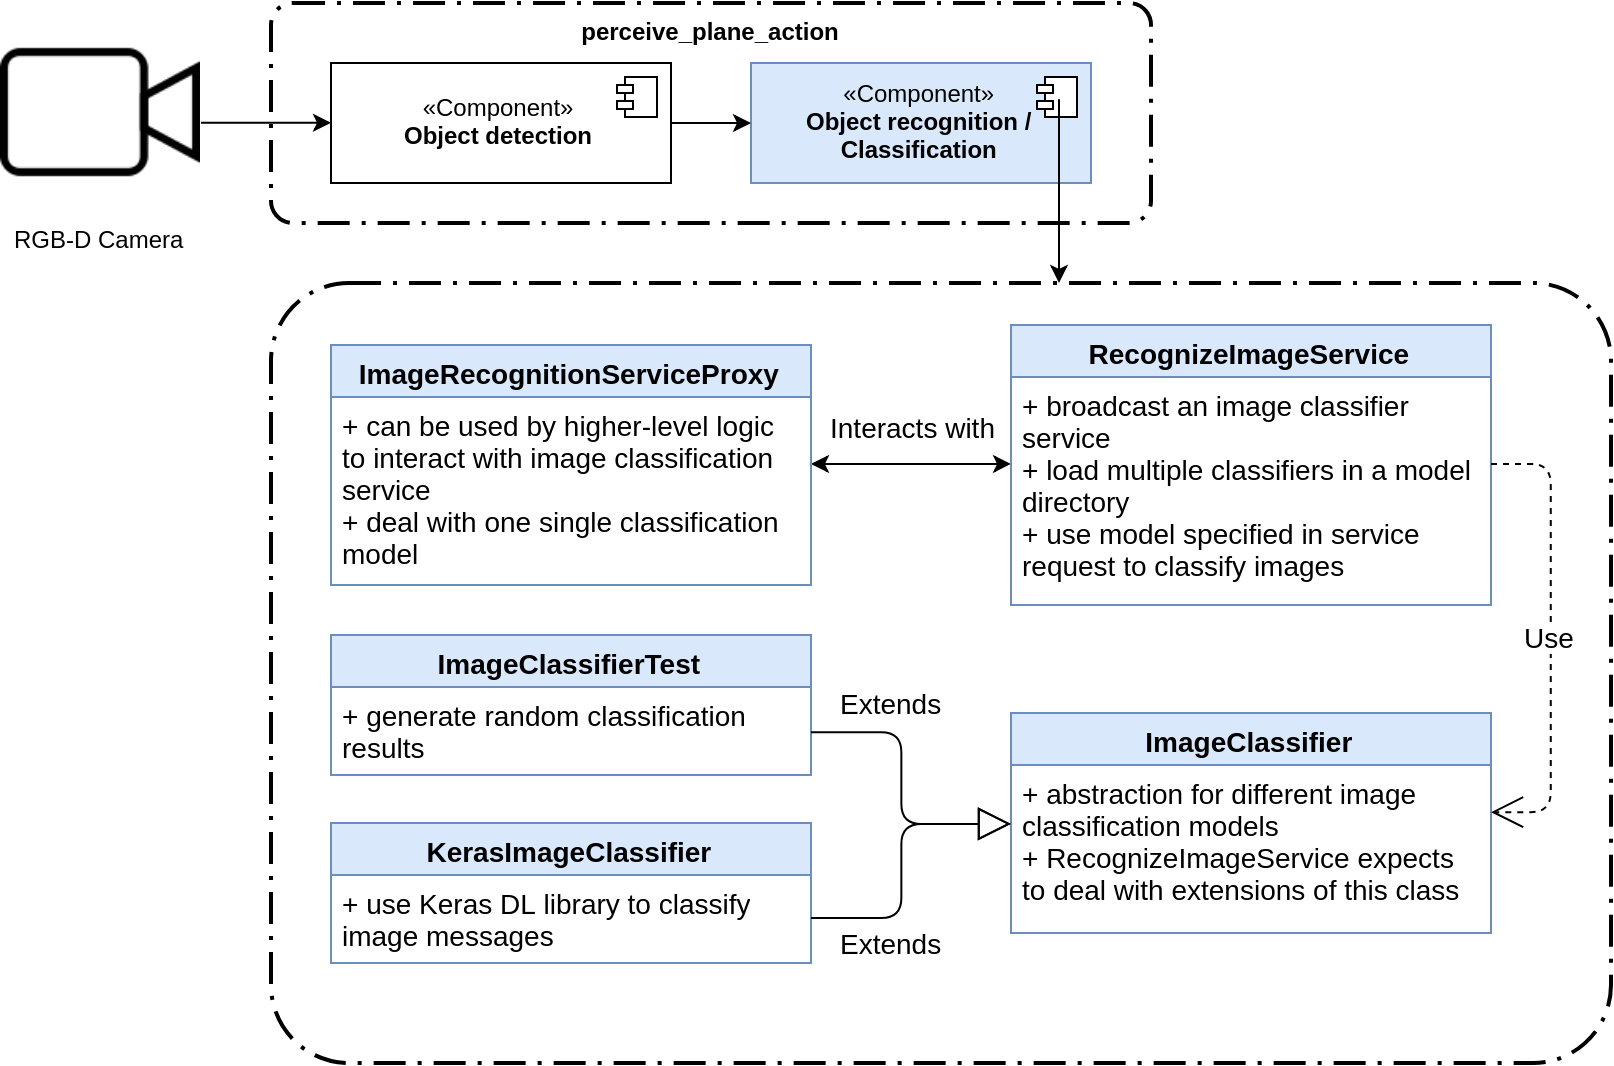

In [7]:
display.Image('images/perception_arch_recognition.png', width=800)

## `mas_perception_libs`

[`mas_perception_libs`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/) is where almost all of the above components are implemented. Other than